In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import sklearn

df = pd.read_csv('../../data/processed/engineered.csv')

df = df.sort_values('date')

## Initial set of columns

First I'm testing using all of the rolling average columns, and putting them in an XGBoost model

In [2]:
features = [
    'eFG_pct_avg_last_20', 'tov_rate_avg_last_20', 'oreb_pct_avg_last_20', 'ftr_avg_last_20',
    'ortg_avg_last_20', 'drtg_avg_last_20', 'covered_avg_last_20', 
    'eFG_pct_avg_last_10', 'tov_rate_avg_last_10', 'oreb_pct_avg_last_10', 'ftr_avg_last_10',
    'ortg_avg_last_10', 'drtg_avg_last_10', 'covered_avg_last_10', 
    # 'days_of_rest', 
    # 'opp_days_of_rest',
    'home_team', 
    'opp_ortg_avg_last_20', 'opp_drtg_avg_last_20',
    'opp_ortg_avg_last_10', 'opp_drtg_avg_last_10',
]


target = 'covered'

df[features].shape

(44719, 19)

## Baseline model

XGBClassifier with 10 game rolling averages of eFG%, tov_rate, oreb%, ftr, ortg, drtg, ATS, opp_ortg, opp_drtg.
Also including 

In [3]:
def train_model(features, df):
    # df = df.sort_values('date')

    X = df[features]
    y = df['covered']

    # Cross-validation for evaluation
    print("=" * 60)
    print("CROSS-VALIDATION RESULTS")
    print("=" * 60)

    tscv = TimeSeriesSplit(n_splits=5)
    cv_aucs = []
    cv_accs = []

    for i, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        model = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            enable_categorical=True,
            tree_method='hist',
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        
        preds = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, preds)
        acc = accuracy_score(y_test, (preds > 0.5).astype(int))
        
        cv_aucs.append(auc)
        cv_accs.append(acc)
        
        print(f"Split {i} | AUC: {auc:.3f} | Accuracy: {acc:.3f}")

    print(f"\nAverage AUC: {sum(cv_aucs)/len(cv_aucs):.3f}")
    print(f"Average Accuracy: {sum(cv_accs)/len(cv_accs):.3f}")

    df.loc[test_idx, 'pred_prob'] = preds
    df = df.sort_values('date')

    return (df, model)

In [4]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

df['rest_category_encoded'] = df['rest_category'].astype('category')

categorical_features = ['rest_category_encoded']
all_f = features + categorical_features

rets = train_model(all_f, df)
df = rets[0]
model = rets[1]

CROSS-VALIDATION RESULTS
Split 1 | AUC: 0.802 | Accuracy: 0.725
Split 2 | AUC: 0.805 | Accuracy: 0.725
Split 3 | AUC: 0.786 | Accuracy: 0.710
Split 4 | AUC: 0.761 | Accuracy: 0.691
Split 5 | AUC: 0.779 | Accuracy: 0.707

Average AUC: 0.786
Average Accuracy: 0.712


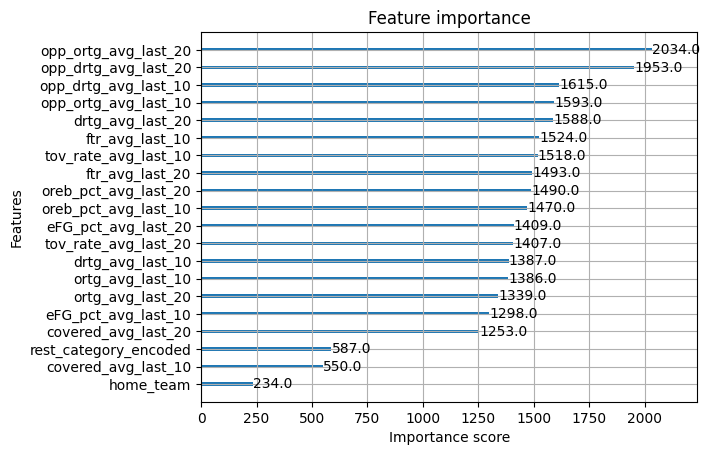

In [5]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

In [6]:
# from sklearn.calibration import calibration_curve
# prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
# plt.plot(prob_pred, prob_true, marker='o')
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Curve')
# plt.show()
# # used for testing, models look good so we should be fine

In [ ]:
# df should already have:
# 'pred_prob' (model's predicted probability of covering)
# 'covered' (actual result, 1 or 0)
# 'spread' (for reference)
# 'date' (for time sorting)

df = df.sort_values('date')


# Betting thresholds
upper_thresh = 0.8  # confident team covers
# lower_thresh = 0.4   # confident team does NOT cover

# Simulate flat 1-unit bets
df['bet_side'] = np.where(df['pred_prob'] > upper_thresh, 1, np.nan)

# Only rows where we made a bet
bets = df.dropna(subset=['bet_side']).copy()

# Payouts assuming -110 odds
WIN_PAYOUT = 0.9091  # profit per unit on win
LOSS_PAYOUT = -1.0

# Compute profit for each bet
bets['bet_outcome'] = np.where(
    (bets['bet_side'] == bets['covered']), WIN_PAYOUT, LOSS_PAYOUT
)

# Track cumulative bankroll
bets['bankroll'] = bets['bet_outcome'].cumsum()


Based on betting on spreads where confidence > 80.0%
Total Bets: 1165
Win Rate: 53.48%
ROI per bet: 0.021
Total Units Won: 24.37


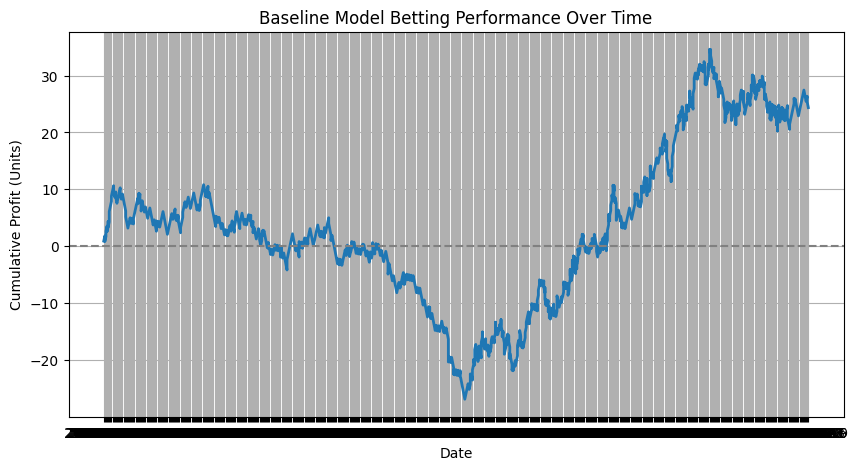

In [8]:
def vis_bets(bets, WIN_PAYOUT=0.9091):
    total_bets = len(bets)
    wins = (bets['bet_outcome'] == WIN_PAYOUT).sum()
    win_rate = wins / total_bets
    roi = bets['bankroll'].iloc[-1] / total_bets

    print(f"Based on betting on spreads where confidence > {upper_thresh*100}%")
    print(f"Total Bets: {total_bets}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"ROI per bet: {roi:.3f}")
    print(f"Total Units Won: {bets['bankroll'].iloc[-1]:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(bets['date'], bets['bankroll'], linewidth=2)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("Baseline Model Betting Performance Over Time")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Profit (Units)")
    plt.grid(True)
    plt.show()

vis_bets(bets)

## Adding a couple more things

Going to add bookie spread, change rest statistics to a difference in rest between teams (positive indicates more rest), and pace. 

CROSS-VALIDATION RESULTS
Split 1 | AUC: 0.802 | Accuracy: 0.721
Split 2 | AUC: 0.805 | Accuracy: 0.726
Split 3 | AUC: 0.787 | Accuracy: 0.710
Split 4 | AUC: 0.760 | Accuracy: 0.687
Split 5 | AUC: 0.778 | Accuracy: 0.706

Average AUC: 0.787
Average Accuracy: 0.710
Total Possible Bets: 44719
Based on betting on spreads where confidence > 60.0%
Total Bets: 2799
Win Rate: 50.73%
ROI per bet: -0.031
Total Units Won: -88.08


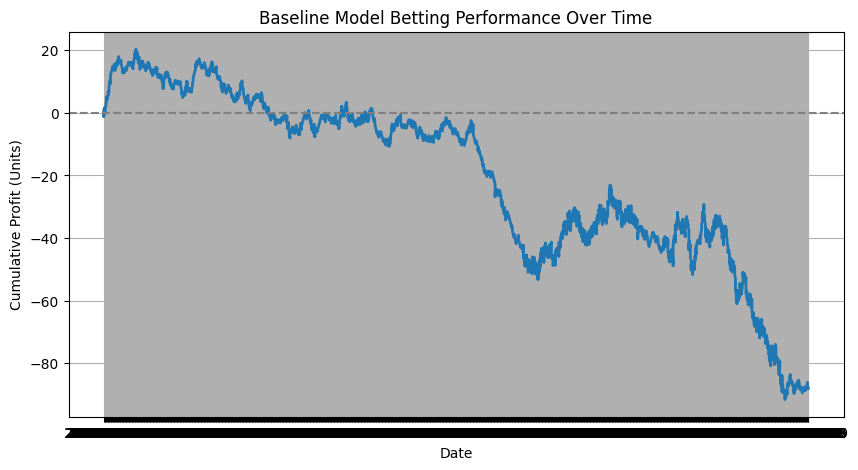

In [14]:
features_v2 = [
    'eFG_pct_avg_last_20', 'tov_rate_avg_last_20', 'oreb_pct_avg_last_20', 'ftr_avg_last_20',
    'ortg_avg_last_20', 'drtg_avg_last_20', 'covered_avg_last_20', 
    'eFG_pct_avg_last_5', 'tov_rate_avg_last_5', 'oreb_pct_avg_last_5', 'ftr_avg_last_5',
    'ortg_avg_last_5', 'drtg_avg_last_5', 'covered_avg_last_5', 
    # 'days_of_rest', 
    # 'opp_days_of_rest',
    'home_team', 
    'opp_ortg_avg_last_20', 'opp_drtg_avg_last_20',
    'opp_ortg_avg_last_5', 'opp_drtg_avg_last_5',
    'rest_category_encoded'
]

df_2 = pd.read_csv('../../data/processed/engineered.csv')
df_2 = df_2.sort_values('date')
df_2['rest_category_encoded'] = df_2['rest_category'].astype('category')

rets = train_model(features_v2, df_2)
df_2 = rets[0]
model_2 = rets[1]

# Betting thresholds
upper_thresh = 0.6   # confident team covers
# lower_thresh = 0.4   # confident team does NOT cover

# Simulate flat 1-unit bets
df_2['bet_side'] = np.where(df_2['pred_prob'] > upper_thresh, 1, np.nan)

# Only rows where we made a bet
bets_2 = df_2.dropna(subset=['bet_side']).copy()

# Payouts assuming -110 odds
WIN_PAYOUT = 0.9091  # profit per unit on win
LOSS_PAYOUT = -1.0

# Compute profit for each bet
bets_2['bet_outcome'] = np.where(
    (bets_2['bet_side'] == bets_2['covered']), WIN_PAYOUT, LOSS_PAYOUT
)

# Track cumulative bankroll
bets_2['bankroll'] = bets_2['bet_outcome'].cumsum()

print(f'Total Possible Bets: {df.shape[0]}')
vis_bets(bets_2)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

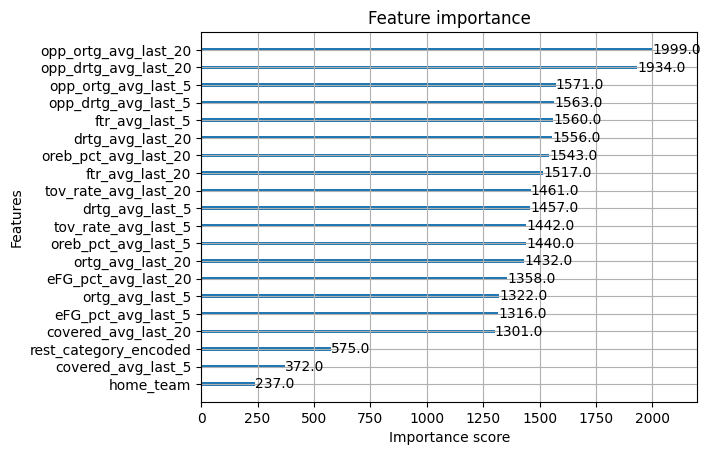

In [10]:
plot_importance(model_2)